In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.nn.functional as F

# Visualization tools
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dataset_size = 1000

# load csv into dataframe 
data = pd.read_csv("epstein_50K_raw.csv", nrows=dataset_size)

# Split the data into training and validation sets
train_data, valid_data = train_test_split(data, test_size=0.2, random_state=42)


scaler = StandardScaler()

# skipping 0th time step which is just initialization and has no relation to input
train_Y_scaled = scaler.fit_transform(train_data.iloc[:, 4:])
valid_Y_scaled = scaler.transform(valid_data.iloc[:, 4:])

In [19]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe):
        self.X = torch.tensor(dataframe.iloc[:, :3].values, dtype=torch.float32)  # Input: [Batch, 3]  
        # train on scaled values 
        self.Y = torch.tensor(train_Y_scaled, dtype=torch.float32).unsqueeze(-1) # Output: [Batch, 251, 1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = TimeSeriesDataset(train_data)
# defining batch size here 
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

class ValidationDataset(Dataset):
    def __init__(self, dataframe):
        self.X = torch.tensor(dataframe.iloc[:, :3].values, dtype=torch.float32)  # Input: [Batch, 3]

        # validation dataset is also scaled 
        self.Y = torch.tensor(valid_Y_scaled, dtype=torch.float32).unsqueeze(-1)  # Output: [Batch, 255, 1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Create validation dataset and DataLoader
valid_dataset = ValidationDataset(valid_data)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


#
# definining transformed model with positional encoding 
#

# Positional Encoding for Time Steps
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Add batch dimension

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :].to(x.device)
    
class TransformerTimeSeriesModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_layers, dim_feedforward):
        super(TransformerTimeSeriesModel, self).__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.target_embedding = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=512)  # Safe max length

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.output_layer = nn.Linear(d_model, output_dim)

    def forward(self, x, target_seq):
        # x: [Batch, input_dim]
        # target_seq: [Batch, T, 1]

        memory = self.encoder(x).unsqueeze(1)  # [Batch, 1, d_model]
        memory = memory.repeat(1, target_seq.size(1), 1)  # Match time dimension of decoder

        tgt = self.target_embedding(target_seq)  # [Batch, T, d_model]
        tgt = self.pos_encoder(tgt)

        memory = self.pos_encoder(memory)

        output = self.transformer_decoder(tgt, memory)
        return self.output_layer(output)  # [Batch, T, 1]

In [21]:
def train_model(model, dataloader, optimizer, loss_fn, num_epochs, device):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        for batch in dataloader:
            x, y = batch              # x: [Batch, N], y: [Batch, T]
            x, y = x.to(device), y.to(device)
            
            # Prepare target for teacher forcing
            target_seq = y 
            #target_seq = y[:, :-1]  # All except last time step
            #actual = y[:, 1:]       # All except first time step
            
            # Forward pass
            output = model(x, target_seq)
            loss = loss_fn(output, y)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

In [22]:
import random

def train_model_scheduled_sampling(model, dataloader, optimizer, loss_fn, num_epochs, device,
                                   scheduled_sampling_start=1.0, scheduled_sampling_end=0.0):
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        p_teacher = scheduled_sampling_start - (scheduled_sampling_start - scheduled_sampling_end) * (epoch / (num_epochs - 1))
        
        for batch in dataloader:
            x, y = batch  # x: [Batch, 3], y: [Batch, 255, 1]
            x, y = x.to(device), y.to(device)

            batch_size, seq_len, _ = y.size()
            decoder_input = y[:, 0:1, :]  # first time step

            outputs = []

            for t in range(1, seq_len):
                out = model(x, decoder_input)  # [Batch, t, 1]
                next_pred = out[:, -1:, :]     # last time step predicted

                # Scheduled sampling decision
                use_teacher = (torch.rand(batch_size, 1, 1, device=device) < p_teacher)
                next_input = torch.where(use_teacher, y[:, t:t+1, :], next_pred)

                decoder_input = torch.cat([decoder_input, next_input], dim=1)
                outputs.append(next_pred)

            # Final output tensor: [Batch, seq_len-1, 1]
            outputs = torch.cat(outputs, dim=1)
            target = y[:, 1:, :]  # Ground truth to match (excluding first step)

            loss = loss_fn(outputs, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs} | Teacher forcing prob: {p_teacher:.4f} | Loss: {loss.item():.6f}")


In [23]:
# Model parameters
input_dim = 3      # Number of input features
output_dim = 1     # Predicting one value per time step
seq_length = 251   # Number of time steps in output
d_model = 128      # Embedding dimension for Transformer
nhead = 4          # Number of attention heads
num_layers = 2     # Number of Transformer layers
dim_feedforward = 512  # Feedforward network size

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerTimeSeriesModel(
    input_dim, output_dim, d_model, nhead, num_layers, dim_feedforward
).to(device)


In [24]:
# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_fn = torch.nn.MSELoss()  # Regression loss

# smoothL1Loss does better 
#loss_fn = torch.nn.SmoothL1Loss() 


# Training loop
num_epochs = 10  # Adjust based on dataset size and performance
train_model(model, dataloader, optimizer, loss_fn, num_epochs, device)

#train_model_scheduled_sampling(
#    model,
#    dataloader,
#    optimizer,
#    loss_fn,
#    num_epochs,
#    device=device,
#    scheduled_sampling_start=1.0,   # start with full teacher forcing
#    scheduled_sampling_end=0.0      # end with full autoregression
#)

Epoch 1/10, Loss: 0.05644162744283676
Epoch 2/10, Loss: 0.012142366729676723
Epoch 3/10, Loss: 0.013131992891430855
Epoch 4/10, Loss: 0.008278969675302505
Epoch 5/10, Loss: 0.006628058850765228
Epoch 6/10, Loss: 0.007155837025493383
Epoch 7/10, Loss: 0.006294093560427427
Epoch 8/10, Loss: 0.00485694594681263
Epoch 9/10, Loss: 0.005576630122959614
Epoch 10/10, Loss: 0.004701619036495686


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    
def evaluate_model(model, valid_loader, device, inference_type='zero', sample=1):
    model.eval()  # Set model to evaluation mode
    true_values = []
    predicted_values = []

    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            
            # use zero tensor for decoder input during inference; doesn't work well
            
            if (inference_type == 'zero'): 
                target_seq = torch.zeros(y.shape, device=device)
                y_pred = model(x, target_seq)  # [Batch, 255, 1]

            if (inference_type == 'start'):        
                # use a start token as decoder input during inference; 
                start_token = y[:, :1, :]
                zeros_rest = torch.zeros(y.shape[0], 250, 1).to(device)
                decoder_input = torch.cat([start_token, zeros_rest], dim=1)
                y_pred = model(x, decoder_input)

            # use the valid loader value; sanity check; R^2 should be closed 0.99
            if (inference_type == 'sanity'):
                y_pred = model(x, y)  # [Batch, 255, 1]

            # convert to numpy for metric calculations
            true_values.append(y.cpu().numpy())
            predicted_values.append(y_pred.cpu().numpy())
    
    # convert lists to arrays
    true_values = np.concatenate(true_values, axis=0)  # Shape: [Total Samples, 255, 1]
    predicted_values = np.concatenate(predicted_values, axis=0)  # Shape: [Total Samples, 255, 1]

    
    
    # plot predicted vs actual for one instance 
    for i in range(sample): 
        plt.plot(predicted_values[i],label='predicted')
        plt.plot(true_values[i],label='true')
        plt.legend()
        plt.show()
    
    # compute error metrics
    mse = mean_squared_error(true_values.flatten(), predicted_values.flatten())
    mae = mean_absolute_error(true_values.flatten(), predicted_values.flatten())
    r2 = r2_score(true_values.flatten(), predicted_values.flatten())

    print(f"Validation MSE: {mse:.4f}")
    print(f"Validation MAE: {mae:.4f}")
    print(f"Validation R² Score: {r2:.4f}")

    return mse, mae, r2

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def autoregressive_predict(model, x, y_true, steps=251, type='start'):
    model.eval()
    with torch.no_grad():
        x = x.unsqueeze(0).to(device)  # [1, input_dim]
        first_step = y_true[0].reshape(1, 1, 1).to(device)  # [1, 1, 
        
        if (type == 'zero'): 
            decoder_input = torch.zeros(1, 1, 1).to(device)  # Start with 1 timestep
        else:
            decoder_input = first_step
            
        for _ in range(steps - 1):
            output = model(x, decoder_input)  # [1, t, 1]
            next_step = output[:, -1:, :]     # [1, 1, 1]
            decoder_input = torch.cat([decoder_input, next_step], dim=1)
  
        return decoder_input.squeeze(0).cpu().numpy()  # Shape: [255, 1]
    
def evaluate_model_autoregressive(model, valid_dataset, device, steps=251, sample=1, count=10):
    model.eval()
    true_values = []
    predicted_values = []

    with torch.no_grad():
        for i in range(count):
            x, y_true = valid_dataset[i]  # x: [3], y_true: [255, 1]
            x = x.to(device)

            y_pred = autoregressive_predict(model, x, y_true, steps=steps, type='start')  # [255, 1]

            # Store
            predicted_values.append(y_pred)
            true_values.append(y_true.numpy())

    # convert list to numpy arrays
    predicted_values = np.array(predicted_values)  # [N, 255, 1]
    true_values = np.array(true_values)            # [N, 255, 1]

    # flatten for metrics
    y_pred_flat = predicted_values.flatten()
    y_true_flat = true_values.flatten()

    
    for i in range(sample): 
        # plot predicted vs actual for one instance
        plt.plot(predicted_values[i],label='predicted')
        plt.plot(true_values[i],label='true')
        plt.legend()
        plt.show()
    
    # compute evaluation metrics
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    r2 = r2_score(y_true_flat, y_pred_flat)

    print(f"Validation MSE: {mse:.6f}")
    print(f"Validation MAE: {mae:.6f}")
    print(f"Validation R² Score: {r2:.6f}")

    return mse, mae, r2


def evaluate_model_autoregressive_subset(model, valid_dataset, sample_subset, device, steps=251, sample=1):
    model.eval()
    true_values = []
    predicted_values = []

    with torch.no_grad():
        for i in range(10):
            x, y_true = valid_dataset[sample_subset[i]]  # x: [3], y_true: [255, 1]
            x = x.to(device)

            y_pred = autoregressive_predict(model, x, y_true, steps=steps)  # [255, 1]

            # Store
            predicted_values.append(y_pred)
            true_values.append(y_true.numpy())

    # convert list to numpy arrays
    predicted_values = np.array(predicted_values)  # [N, 255, 1]
    true_values = np.array(true_values)            # [N, 255, 1]

    # flatten for metrics
    y_pred_flat = predicted_values.flatten()
    y_true_flat = true_values.flatten()

    # plot predicted vs actual for one instance
 
    plt.plot(predicted_values[sample],label='predicted')
    plt.plot(true_values[sample],label='true')
    plt.legend()
    plt.show()
    
    # compute evaluation metrics
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    r2 = r2_score(y_true_flat, y_pred_flat)

    print(f"Validation MSE: {mse:.6f}")
    print(f"Validation MAE: {mae:.6f}")
    print(f"Validation R² Score: {r2:.6f}")

    return mse, mae, r2


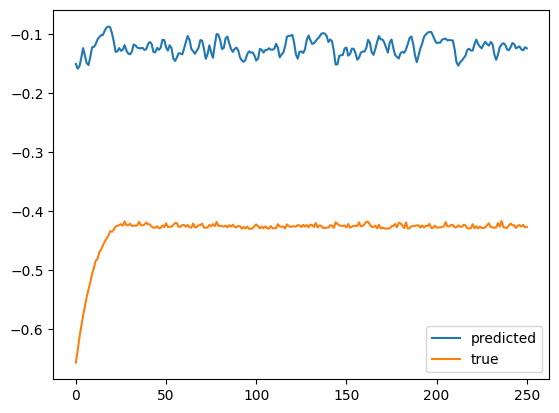

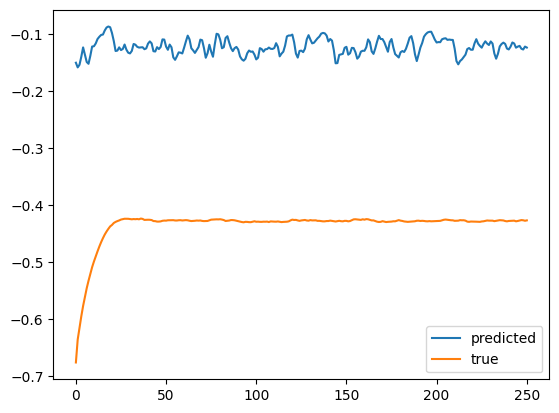

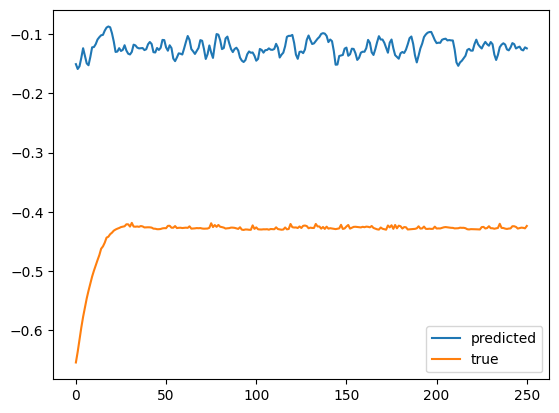

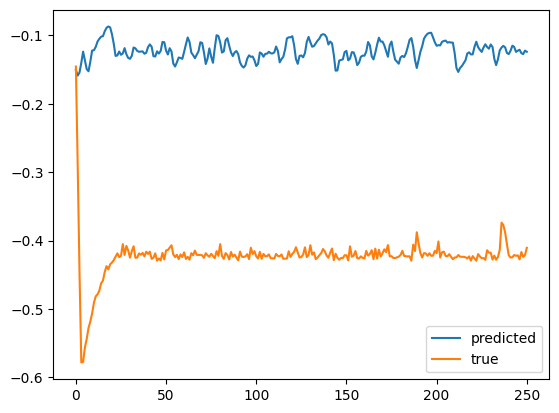

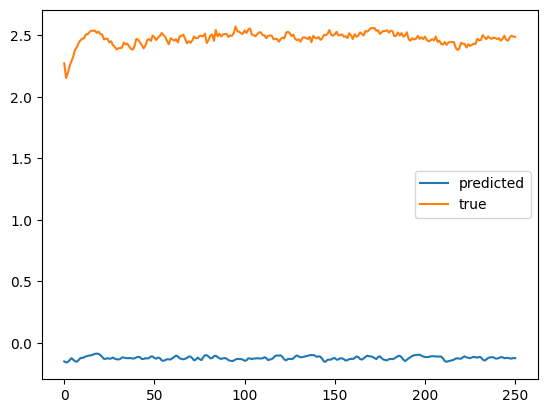

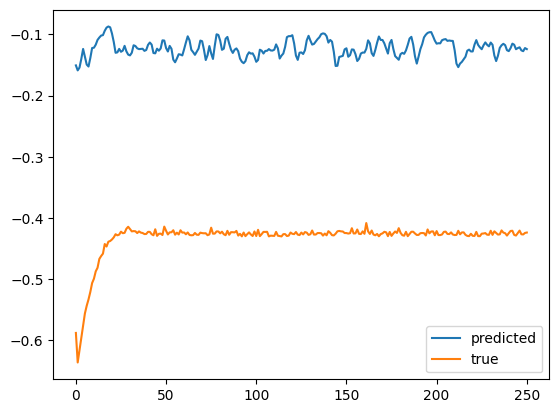

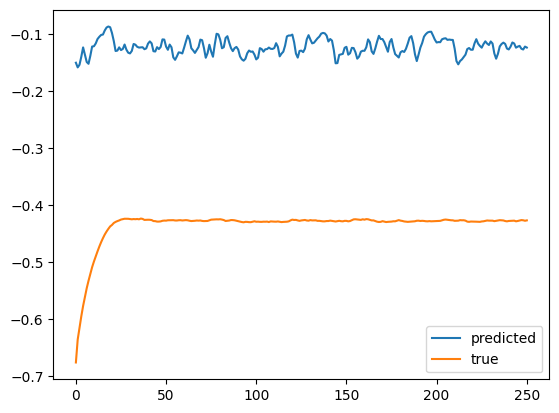

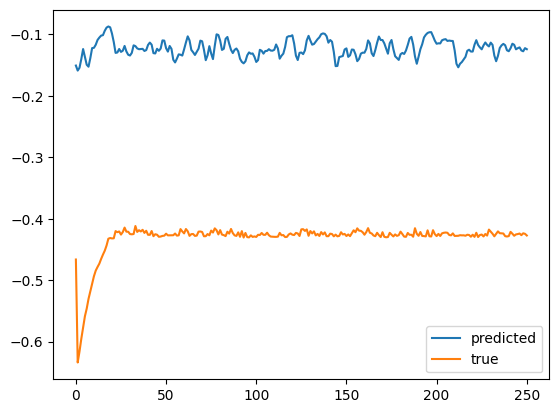

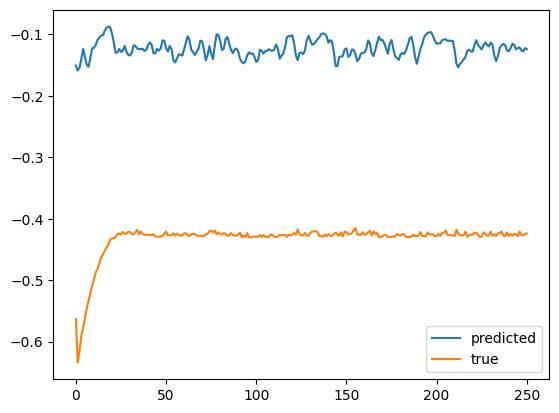

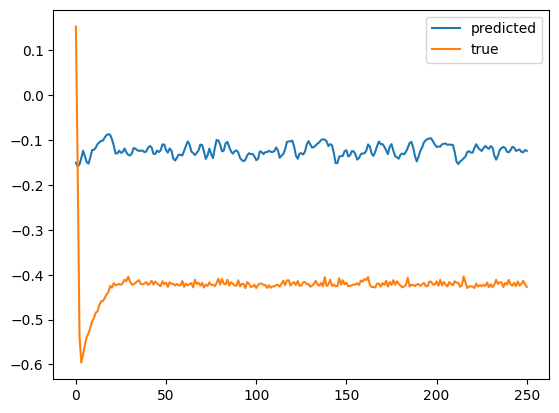

Validation MSE: 1.1439
Validation MAE: 0.6269
Validation R² Score: -0.0183


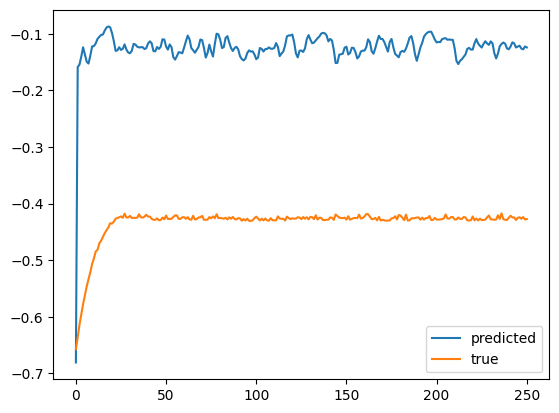

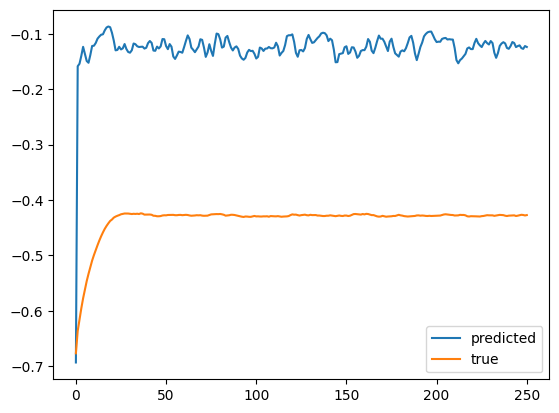

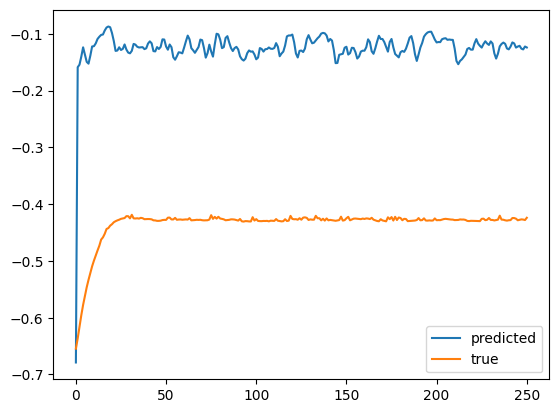

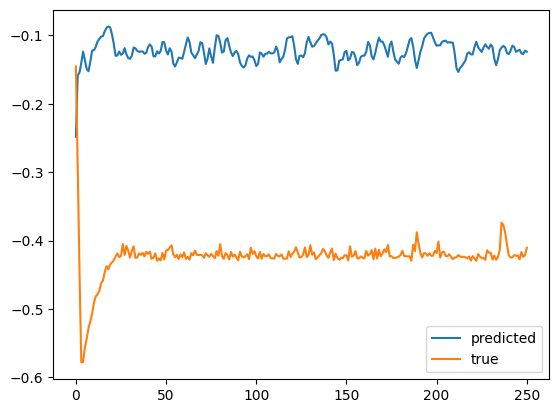

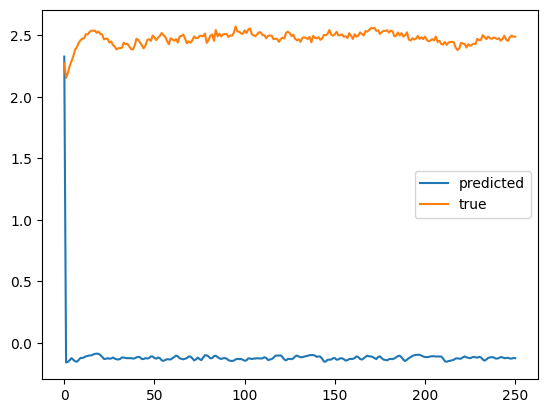

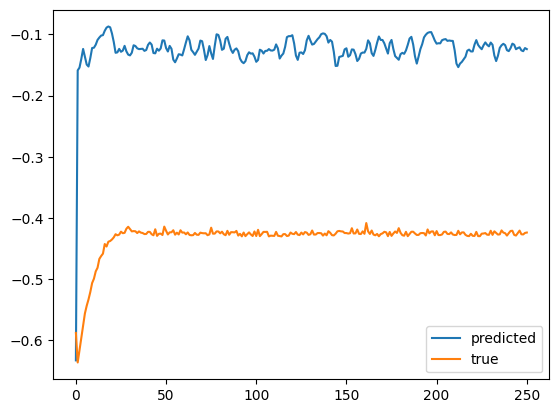

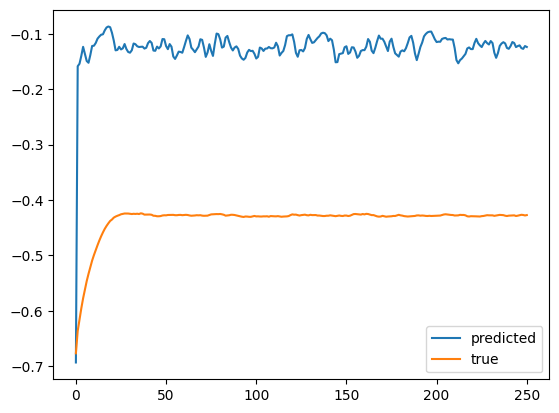

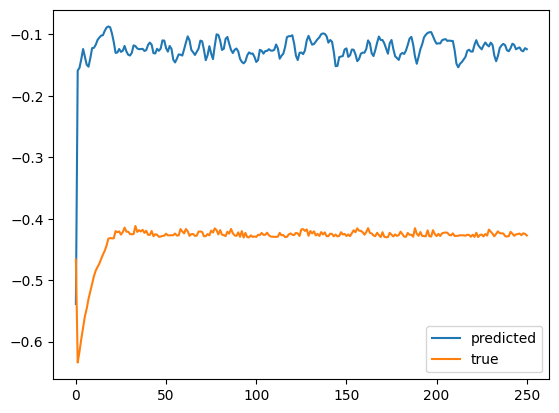

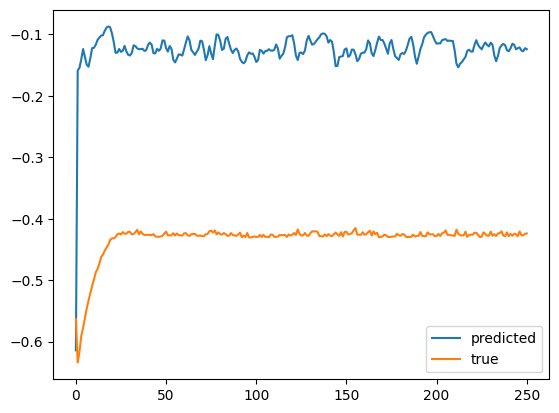

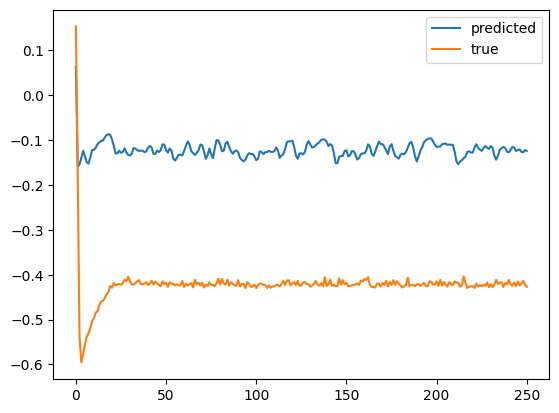

Validation MSE: 1.1397
Validation MAE: 0.6241
Validation R² Score: -0.0145


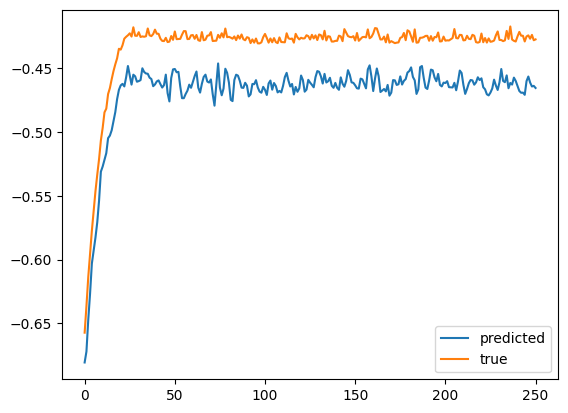

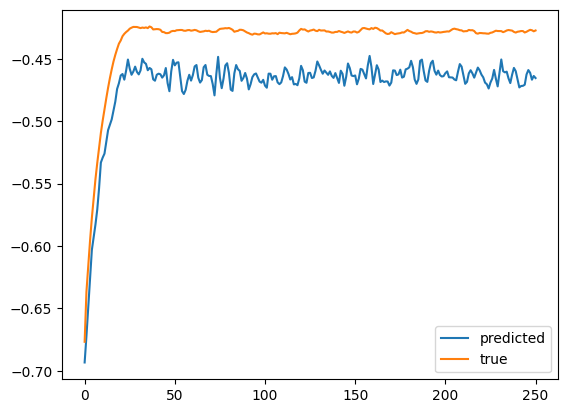

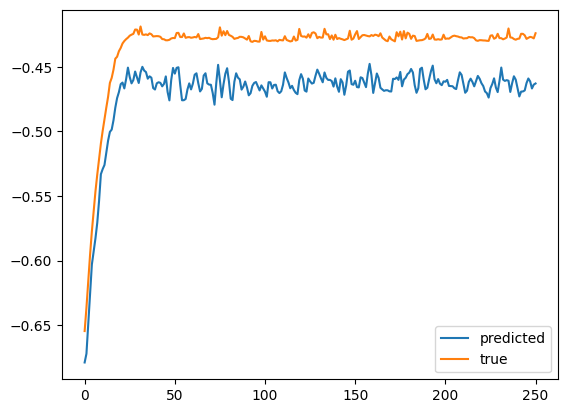

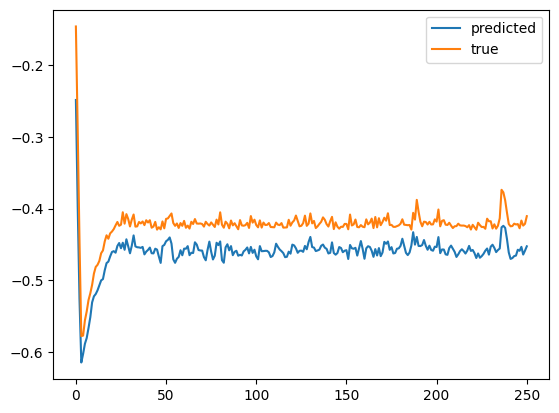

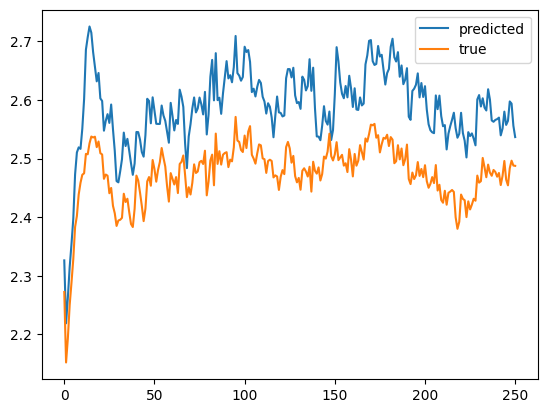

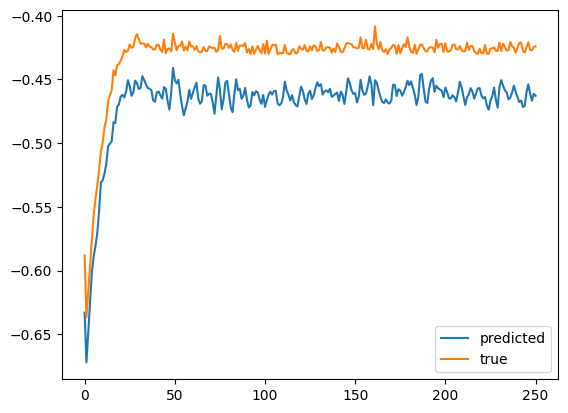

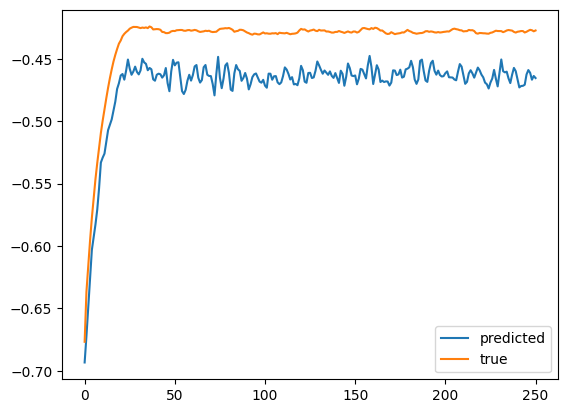

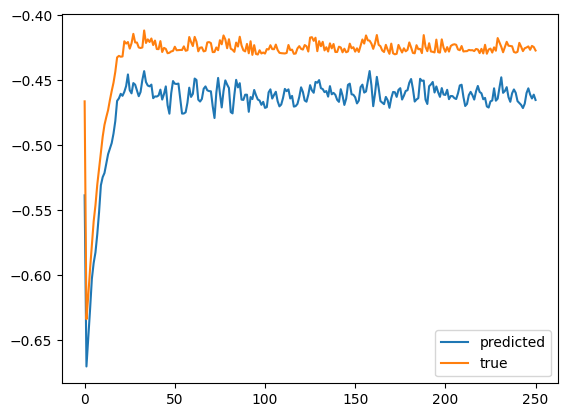

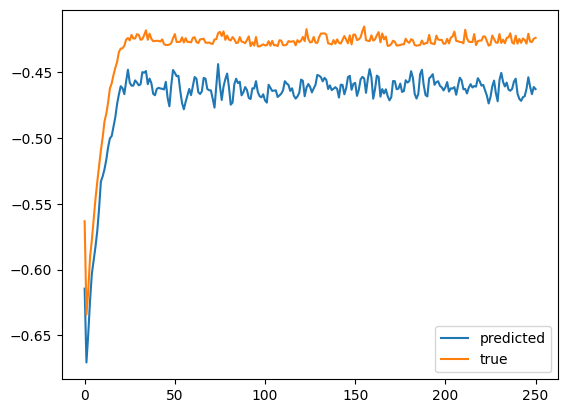

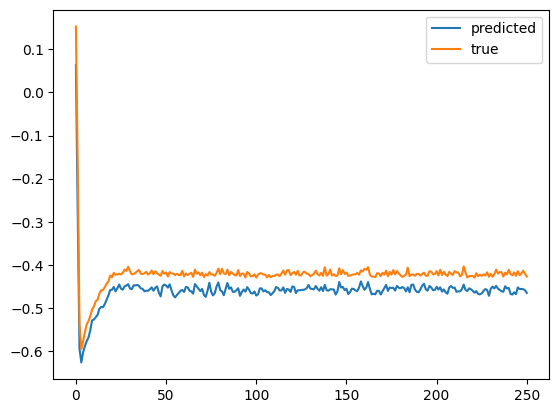

Validation MSE: 0.0050
Validation MAE: 0.0509
Validation R² Score: 0.9955


(0.005012352950870991, 0.050854604691267014, 0.9955381155014038)

In [27]:
evaluate_model(model, valid_loader, device, "zero", sample=10)
evaluate_model(model, valid_loader, device, "start", sample=10)
evaluate_model(model, valid_loader, device, "sanity", sample=10)

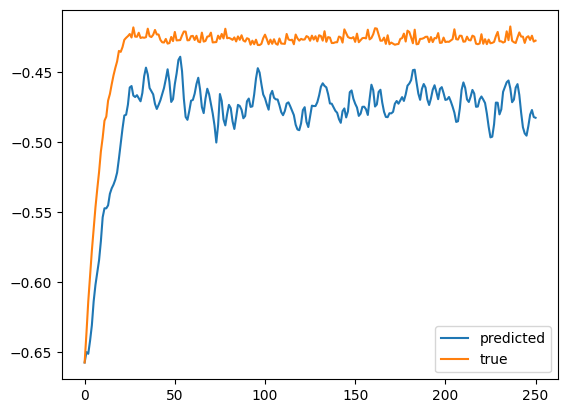

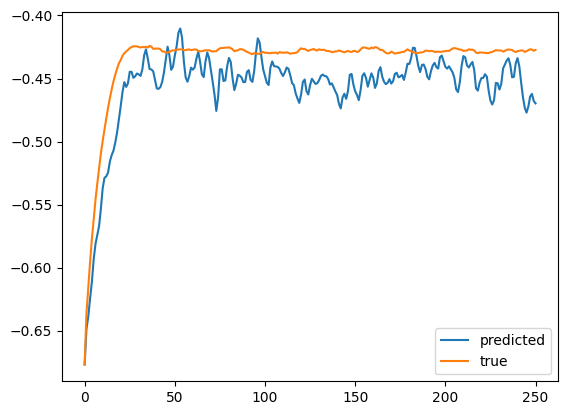

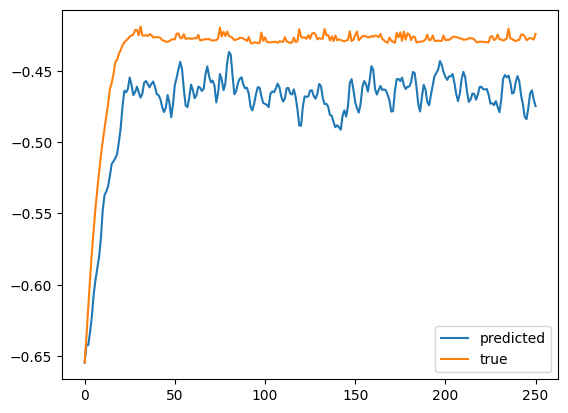

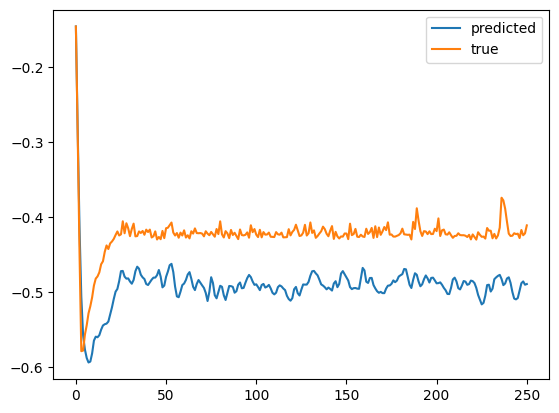

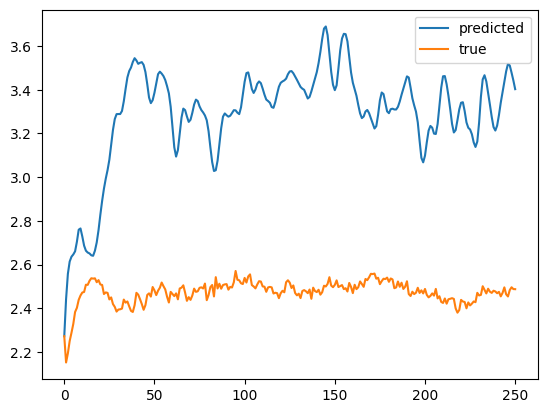

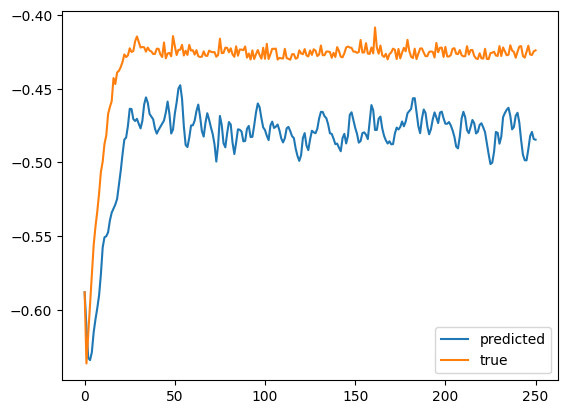

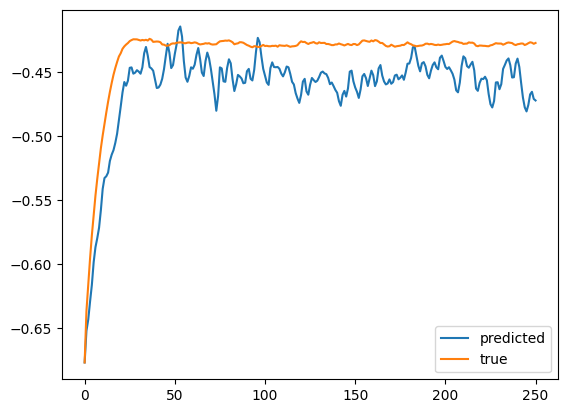

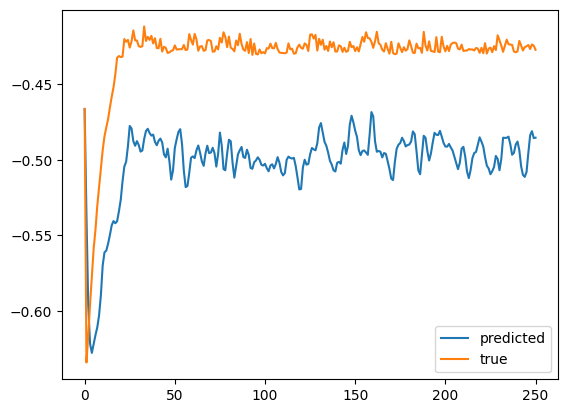

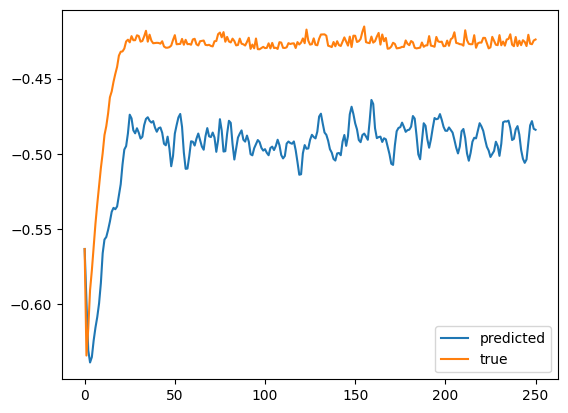

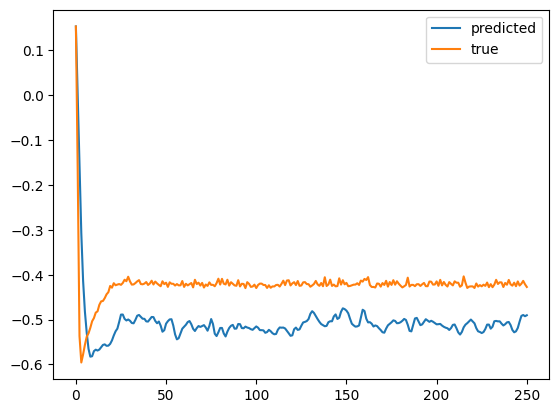

Validation MSE: 0.186318
Validation MAE: 0.197174
Validation R² Score: 0.677205


(0.18631774187088013, 0.19717398285865784, 0.6772048473358154)

In [28]:
evaluate_model_autoregressive(model, valid_dataset, device, sample=10, count=20)

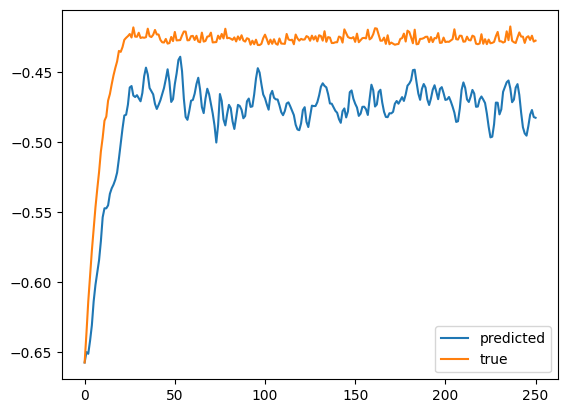

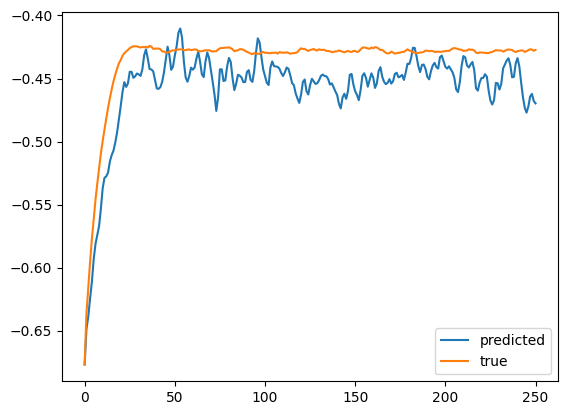

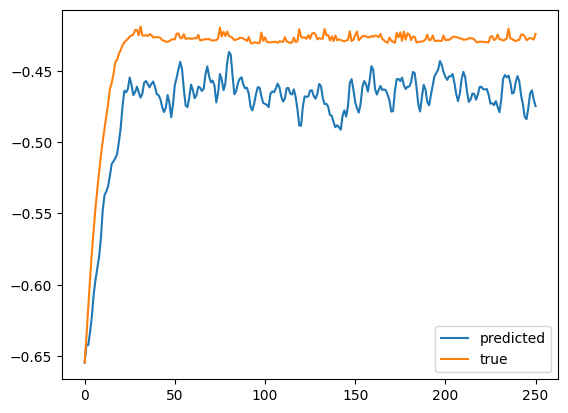

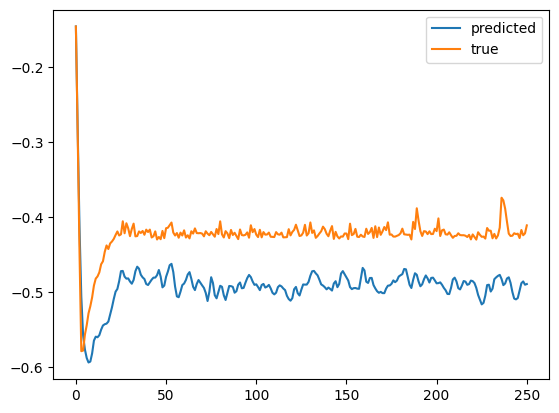

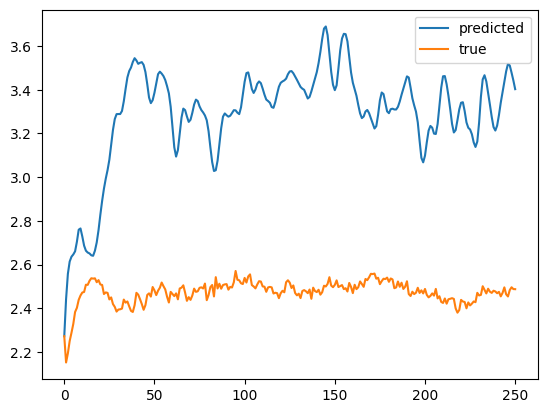

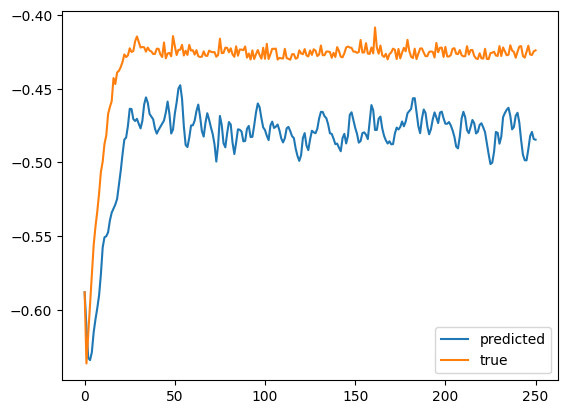

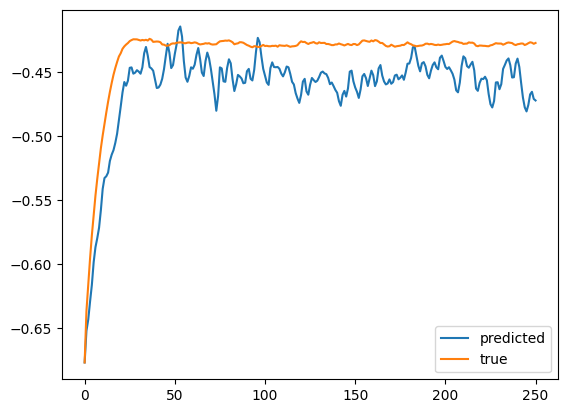

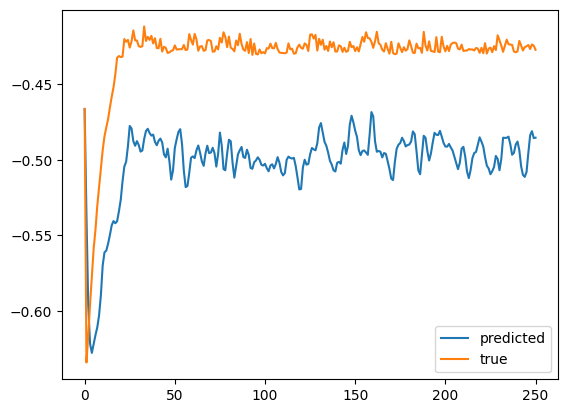

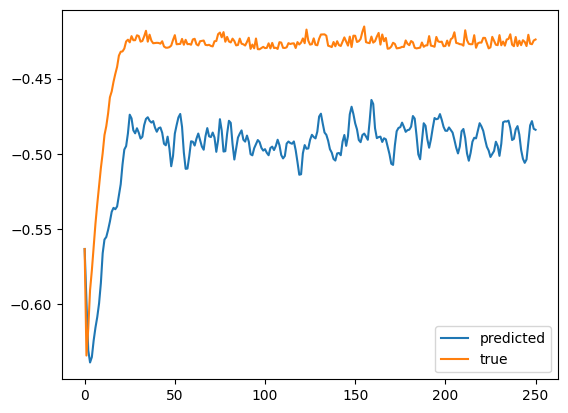

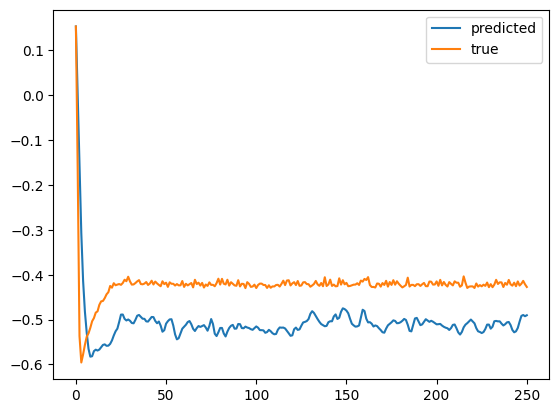

Validation MSE: 0.632600
Validation MAE: 0.333387
Validation R² Score: 0.436873


(0.6326003074645996, 0.33338719606399536, 0.43687301874160767)

In [29]:
evaluate_model_autoregressive(model, valid_dataset, device, sample=10, count=len(valid_dataset)) 

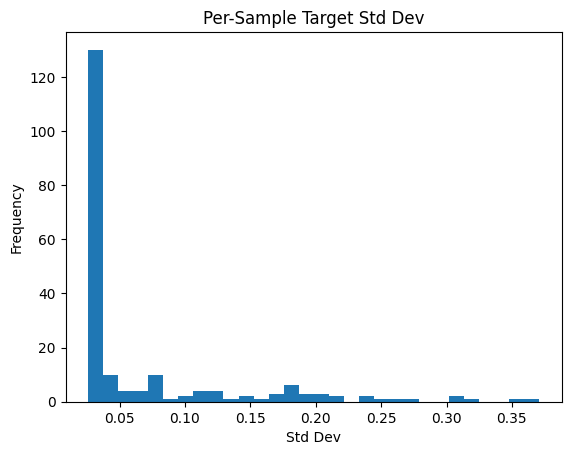

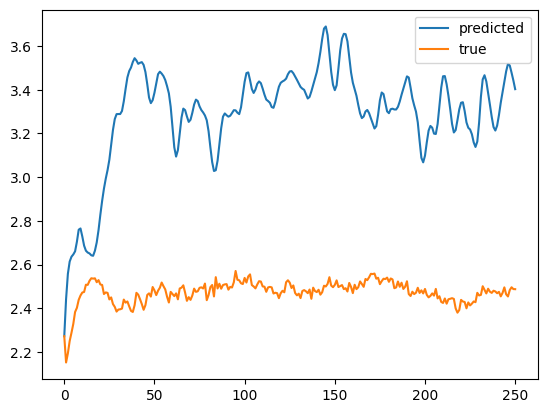

Validation MSE: 0.407119
Validation MAE: 0.415128
Validation R² Score: 0.831136


(0.4071189761161804, 0.41512829065322876, 0.8311360478401184)

In [30]:
stds = []
for i in range(len(valid_dataset)):
    _, y_true = valid_dataset[i][:2]
    stds.append(np.std(y_true.numpy()))

import matplotlib.pyplot as plt
plt.hist(stds, bins=30)
plt.title("Per-Sample Target Std Dev")
plt.xlabel("Std Dev")
plt.ylabel("Frequency")
plt.show()

flat_samples = [i for i, std in enumerate(stds) if std < 0.05]
nonflat_samples = [i for i, std in enumerate(stds) if std >= 0.05]

evaluate_model_autoregressive_subset(model, valid_dataset, nonflat_samples, device, sample=0)

Validation MSE: 0.000616
Validation MAE: 0.021874
Validation R² Score: 0.390901


C:\Users\met48\AppData\Local\Temp\ipykernel_13408\1431956246.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  true_values = np.array(sample_y)            # [N, 255, 1]


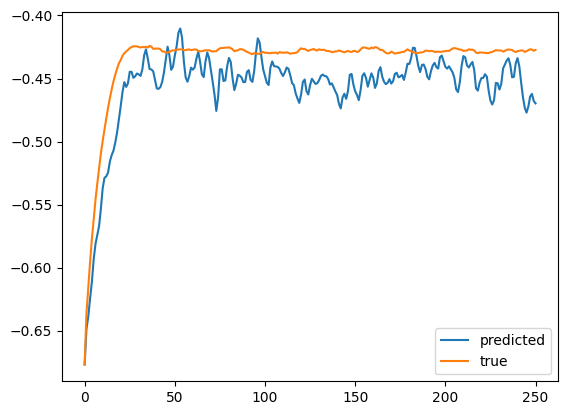

In [31]:
sample_x, sample_y = valid_dataset[1]  # Or a batch    
pred = autoregressive_predict(model, sample_x, sample_y)

# Convert to numpy arrays
#predicted_values = np.array(pred_original)  # [N, 255, 1]
#true_values = np.array(true_original)     

predicted_values = np.array(pred)  # [N, 255, 1]
true_values = np.array(sample_y)            # [N, 255, 1]

# Flatten for metrics
y_pred_flat = predicted_values.flatten()
y_true_flat = true_values.flatten()

# Compute evaluation metrics
mse = mean_squared_error(y_true_flat, y_pred_flat)
mae = mean_absolute_error(y_true_flat, y_pred_flat)
r2 = r2_score(y_true_flat, y_pred_flat)

print(f"Validation MSE: {mse:.6f}")
print(f"Validation MAE: {mae:.6f}")
print(f"Validation R² Score: {r2:.6f}")
    
plt.plot(pred.flatten(), label='predicted')
plt.plot(sample_y.numpy().flatten(), label='true')
plt.legend()
plt.show()